In [1]:
"""
solving pendulum using actor-critic model
"""

import gym
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, GRU, Masking
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

import tensorflow as tf

import random
from collections import deque

def stack_samples(samples):
	array = np.array(samples)
	
	current_states = np.stack(array[:,0]).reshape((array.shape[0],-1,array[0,0].shape[2]))
	current_act_hists = np.stack(array[:,1]).reshape((array.shape[0],-1,array[0,1].shape[2]))
	actions = np.stack(array[:,2]).reshape((array.shape[0],-1))
	rewards = np.stack(array[:,3]).reshape((array.shape[0],-1))
	new_states = np.stack(array[:,4]).reshape((array.shape[0],-1,array[0,4].shape[2]))
	new_act_hists = np.stack(array[:,5]).reshape((array.shape[0],-1,array[0,5].shape[2]))
	dones = np.stack(array[:,6]).reshape((array.shape[0],1))
	
	return current_states, current_act_hists, actions, rewards, new_states, new_act_hists, dones

# determines how to assign values to each state, i.e. takes the state
# and action (two-input model) and determines the corresponding value
class ActorCritic:
	def __init__(self, env, sess):
		self.env  = env
		self.sess = sess

		self.learning_rate = 0.0001
		self.epsilon = .9
		self.epsilon_decay = .99995
		self.gamma = .90
		self.tau   = .01

		# ===================================================================== #
		#                               Actor Model                             #
		# Chain rule: find the gradient of chaging the actor network params in  #
		# getting closest to the final value network predictions, i.e. de/dA    #
		# Calculate de/dA as = de/dC * dC/dA, where e is error, C critic, A act #
		# ===================================================================== #
		self.ema = tf.train.ExponentialMovingAverage(decay=1-self.tau)
		self.memory = deque(maxlen=4000)
		self.actor_state_input, self.actor_act_hist_input, self.actor_model = self.create_actor_model()
		_,_, self.target_actor_model = self.create_actor_model()

		self.actor_critic_grad = tf.placeholder(tf.float32,
			[None, self.env.action_space.shape[0]]) # where we will feed de/dC (from critic)

		actor_model_weights = self.actor_model.trainable_weights
		self.actor_grads = tf.gradients(self.actor_model.output,
			actor_model_weights, -self.actor_critic_grad) # dC/dA (from actor)
		grads = zip(self.actor_grads, actor_model_weights)
		self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)

		# ===================================================================== #
		#                              Critic Model                             #
		# ===================================================================== #

		self.critic_state_input, self.critic_act_hist_input, self.critic_action_input, \
			self.critic_model = self.create_critic_model()
		_, _, _,self.target_critic_model = self.create_critic_model()

		self.critic_grads = tf.gradients(self.critic_model.output,
			self.critic_action_input) # where we calcaulte de/dC for feeding above

		# Initialize for later gradient calculations
		self.sess.run(tf.initialize_all_variables())

	# ========================================================================= #
	#                              Model Definitions                            #

	def create_actor_model(self):
	# ========================================================================= #
		state_input = Input(shape=(None,self.env.observation_space.shape[0]))
		act_hist_input = Input(shape=(None,self.env.action_space.shape[0]))
		mask_state_input = Masking(mask_value=0.)(state_input)
		mask_action_input = Masking(mask_value=0.)(act_hist_input)
		h1 = Dense(500, activation='relu')(Concatenate()([mask_state_input,mask_action_input]))
		actor_rnn,state_h = GRU(256, return_state=True)(h1)
		h2 = Dense(500, activation='relu')(state_h)
		output = Dense(self.env.action_space.shape[0], activation='tanh')(h2)

		model = Model([state_input,act_hist_input], output)
		adam  = Adam(lr=0.0001)
		model.compile(loss="mse", optimizer=adam)
		return state_input, act_hist_input, model

	def create_critic_model(self):
		state_input = Input(shape=(None,self.env.observation_space.shape[0]))
		act_hist_input = Input(shape=(None,self.env.action_space.shape[0]))
		mask_state_input = Masking(mask_value=0.)(state_input)
		mask_action_input = Masking(mask_value=0.)(act_hist_input)
		state_h1 = Dense(500, activation='relu')(Concatenate()([mask_state_input,mask_action_input]))
		critic_rnn,state_h2 = GRU(256, return_state=True)(state_h1)

		action_input = Input(shape=self.env.action_space.shape)
		action_h1    = Dense(500)(action_input)

		merged    = Concatenate()([state_h2, action_h1])
		merged_h1 = Dense(500, activation='relu')(merged)
		output = Dense(1, activation='linear')(merged_h1)
		model  = Model([state_input,act_hist_input,action_input],output)

		adam  = Adam(lr=0.0001)
		model.compile(loss="mse", optimizer=adam)
		return state_input, act_hist_input, action_input, model

	# ========================================================================= #
	#                               Model Training                              #
	# ========================================================================= #

	def remember(self, cur_state, cur_act_hist, action, reward, new_state, new_act_hist, done):
		self.memory.append([cur_state, cur_act_hist, action, reward, new_state, new_act_hist, done])

	def _train_actor(self, samples):
		
			cur_states, cur_act_hists, actions, rewards, new_states,new_act_hists, _ =  stack_samples(samples)
			predicted_actions = self.actor_model.predict([cur_states,cur_act_hists])
			grads = self.sess.run(self.critic_grads, feed_dict={
				self.critic_state_input:  cur_states,
                self.critic_act_hist_input: cur_act_hists,
				self.critic_action_input: predicted_actions
			})[0]

			self.sess.run(self.optimize, feed_dict={
				self.actor_state_input: cur_states,
                self.actor_act_hist_input: cur_act_hists,
				self.actor_critic_grad: grads
			})

	def _train_critic(self, samples):
   

		cur_states, cur_act_hists, actions, rewards, new_states,new_act_hists, dones = stack_samples(samples)
		target_actions = self.target_actor_model.predict([new_states,new_act_hists])
		future_rewards = self.target_critic_model.predict([new_states, new_act_hists,target_actions])
		dones = dones.reshape(rewards.shape)
		future_rewards = future_rewards.reshape(rewards.shape)
		rewards += self.gamma * future_rewards * (1 - dones)
		
		evaluation = self.critic_model.fit([cur_states, cur_act_hists, actions], rewards, verbose=0)
		#print(evaluation.history)
        
	def train(self):
		batch_size = 256
		if len(self.memory) < batch_size:
			return

		rewards = []
		samples = random.sample(self.memory, batch_size)
		self.samples = samples
		self._train_critic(samples)
		self._train_actor(samples)

	# ========================================================================= #
	#                         Target Model Updating                             #
	# ========================================================================= #

	def _update_actor_target(self):
		actor_model_weights  = self.actor_model.get_weights()
		actor_target_weights = self.target_actor_model.get_weights()
		
		for i in range(len(actor_target_weights)):
			actor_target_weights[i] = actor_model_weights[i]*self.tau + actor_target_weights[i]*(1-self.tau)
		self.target_actor_model.set_weights(actor_target_weights)

	def _update_critic_target(self):
		critic_model_weights  = self.critic_model.get_weights()
		critic_target_weights = self.target_critic_model.get_weights()
		
		for i in range(len(critic_target_weights)):
			critic_target_weights[i] = critic_model_weights[i]*self.tau + critic_target_weights[i]*(1-self.tau)
		self.target_critic_model.set_weights(critic_target_weights)

	def update_target(self):
		self._update_actor_target()
		self._update_critic_target()

	# ========================================================================= #
	#                              Model Predictions                            #
	# ========================================================================= #

	def act(self, cur_state, cur_act_hist):
		self.epsilon *= self.epsilon_decay
		if np.random.random() < self.epsilon:
			return self.actor_model.predict([cur_state,cur_act_hist])*2 + np.random.normal()
		return self.actor_model.predict([cur_state,cur_act_hist])*2





/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.
trial:0
[-3449.6426]
[-19.264357]
trial:1
[-2633.126]
[-17.354727]
trial:2
[-3090.0288]
[-19.556746]
trial:3
[-3175.8457]
[-19.497366]
trial:4
[-2121.3281]
[-8.850887]
trial:5
[-3119.805]
[-23.896294]
trial:6
[-3153.6504]
[-17.716124]
trial:7
[-2598.653]
[-11.551169]
trial:8
[-3178.6108]
[-12.019141]
trial:9
[-3107.8318]
[-22.721413]
trial:10
[-2388.9832]
[-9.465526]
trial:11
[-3170.5823]
[-18.64107]
trial:12
[-2803.664]
[-8.691779]
trial:13
[-2772.9155]
[-18.112513]
trial:14
[-3126.1135]
[-15.265609]
trial:15
[-2188.6746]
[-21.935413]
trial:16
[-2990.0364]
[-10.015914]
trial:17
[-2615.1165]
[-18.467842]
trial:18
[-3099.4507]
[-10.983078]
trial:19
[-2441.035]
[-13.855797]
trial:20
[-2692.9465]
[-14.311596]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


trial:21
[-3118.6812]
[-24.76414]
trial:22
[-2908.6748]
[-7.8013735]
trial:23
[-2379.7168]
[-4.9231524]
trial:24
[-3012.6987]
[-20.379253]
trial:25
[-2619.2776]
[-7.7754555]
trial:26
[-2699.9807]
[-9.538373]
trial:27
[-3073.97]
[-16.645744]
trial:28
[-3093.0017]
[-15.747572]
trial:29
[-2176.8235]
[-13.380357]
trial:30
[-2360.3362]
[-10.846812]
trial:31
[-1891.8828]
[-2.7818947]
trial:32
[-3019.0283]
[-9.83644]
trial:33
[-3027.9932]
[-7.988824]
trial:34
[-3036.7874]
[-14.1312475]
trial:35
[-2358.9102]
[-13.466641]
trial:36
[-3237.0786]
[-24.561443]
trial:37
[-2440.9917]
[-17.311829]
trial:38
[-3259.3325]
[-17.23645]
trial:39
[-3199.277]
[-27.296284]
trial:40
[-3067.6536]
[-17.175968]
trial:41
[-3106.0337]
[-14.914036]
trial:42
[-3156.247]
[-32.095074]
trial:43
[-3093.2156]
[-17.408373]
trial:44
[-2681.923]
[-15.898835]
trial:45
[-3085.8987]
[-15.459791]
trial:46
[-2451.475]
[-14.739641]
trial:47
[-3164.1912]
[-29.616478]
trial:48
[-2982.271]
[-14.42188]
trial:49
[-2870.3655]
[-28.06686]

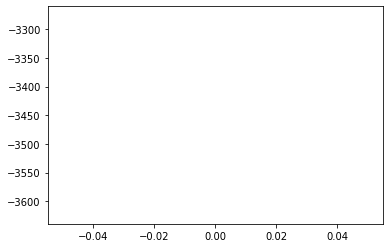

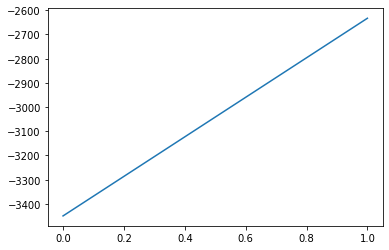

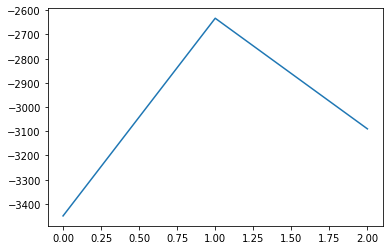

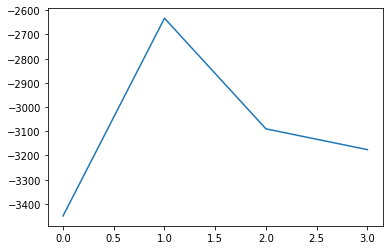

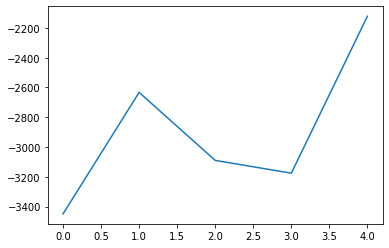

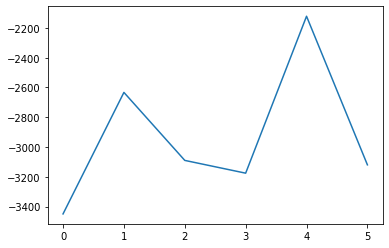

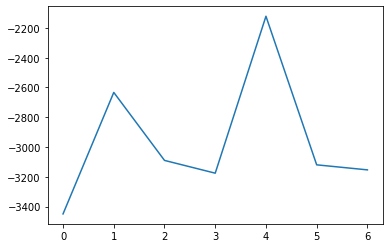

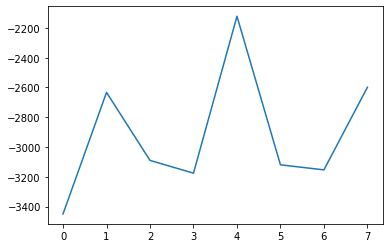

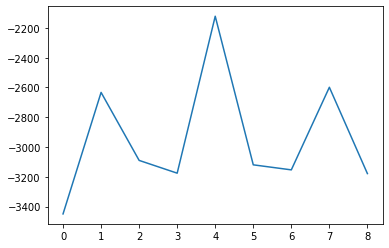

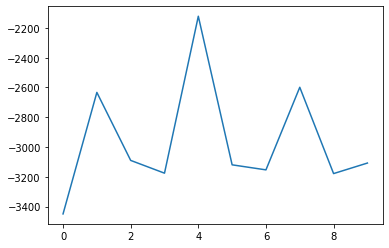

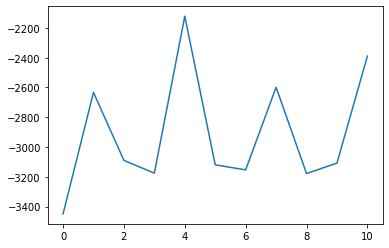

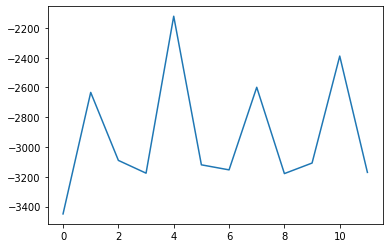

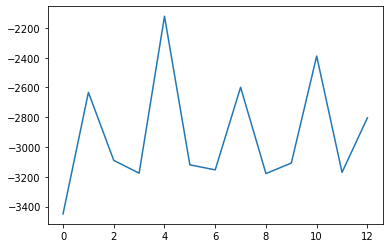

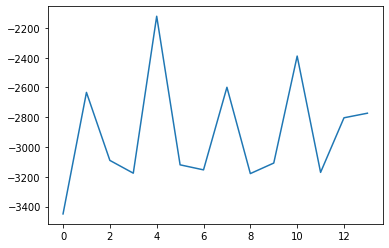

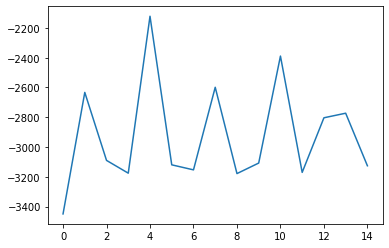

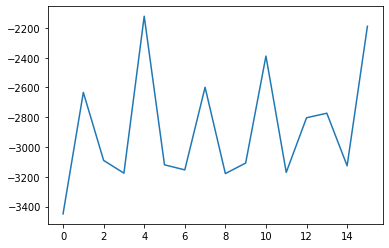

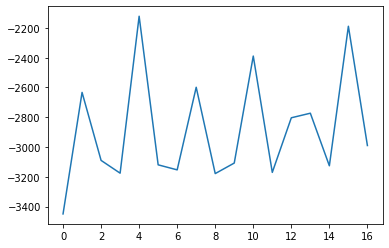

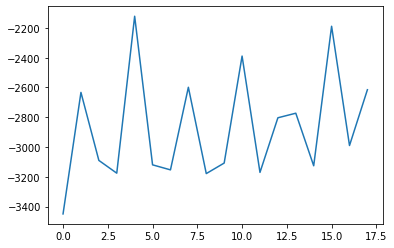

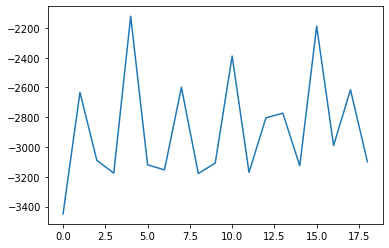

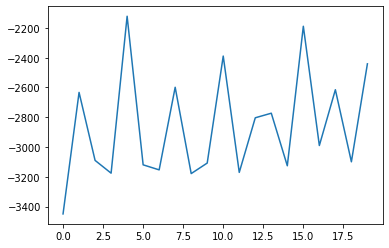

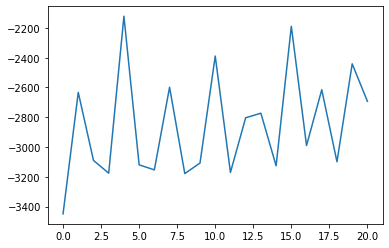

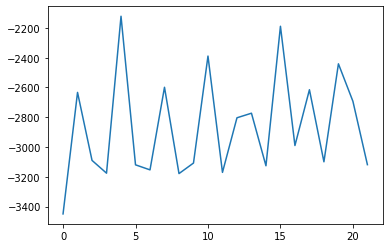

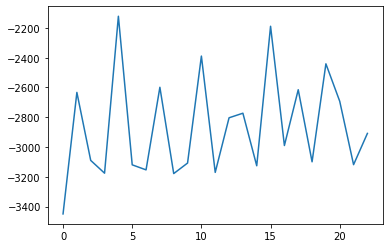

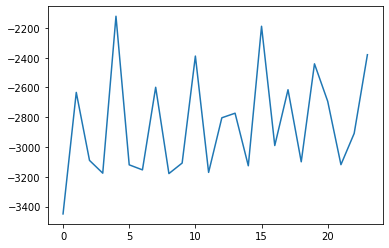

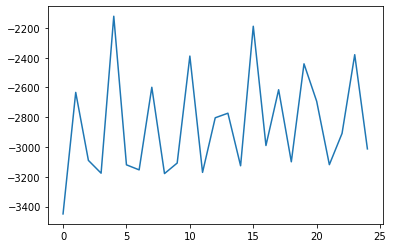

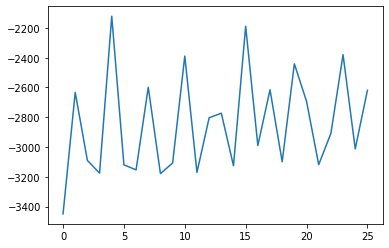

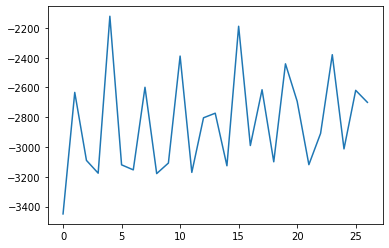

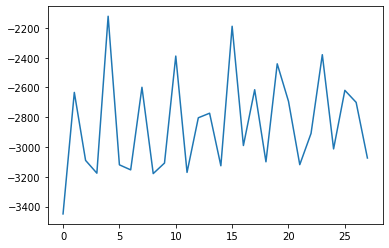

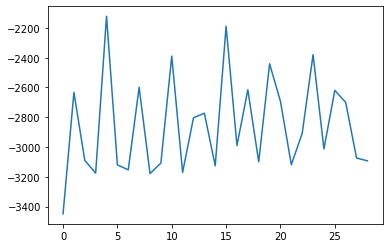

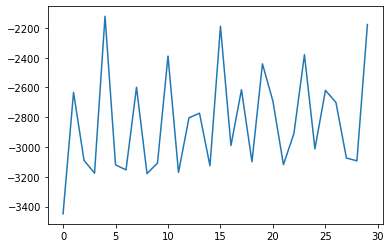

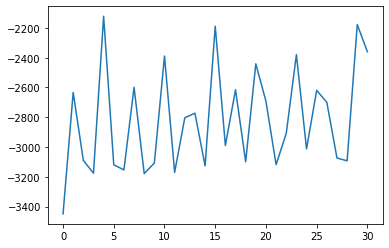

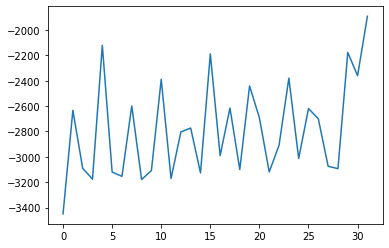

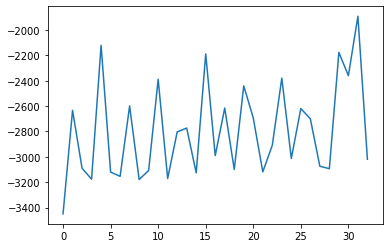

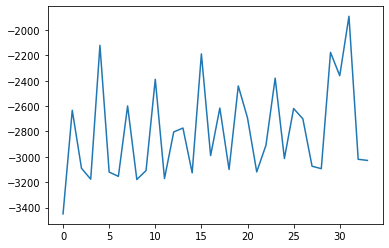

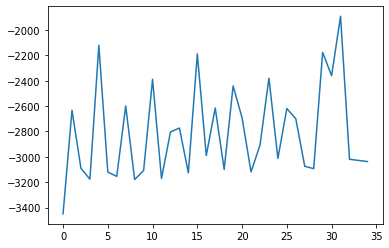

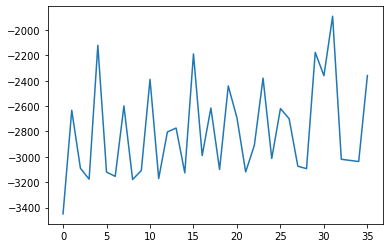

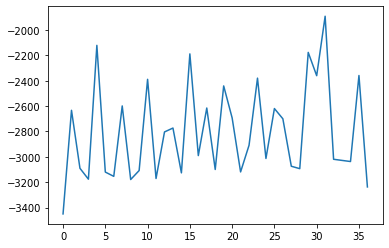

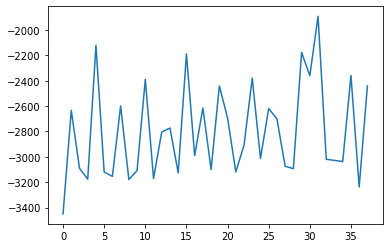

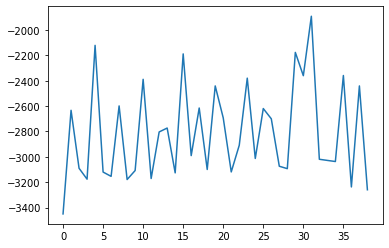

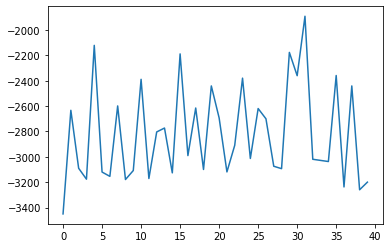

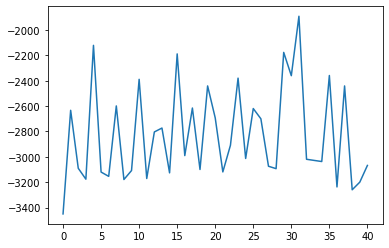

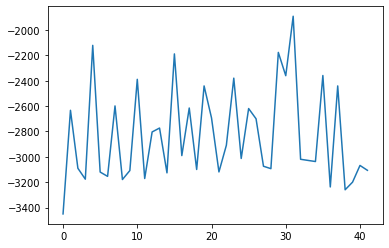

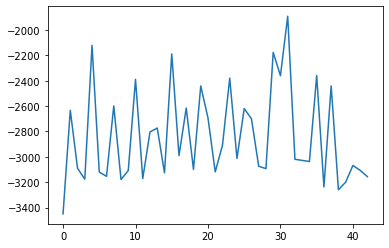

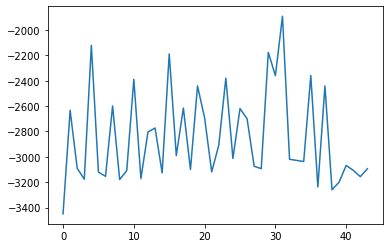

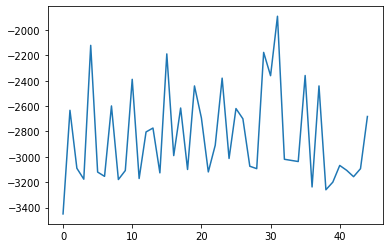

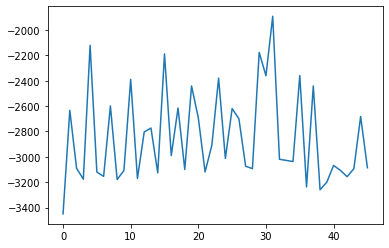

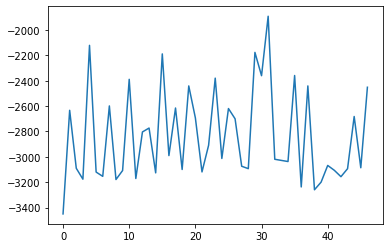

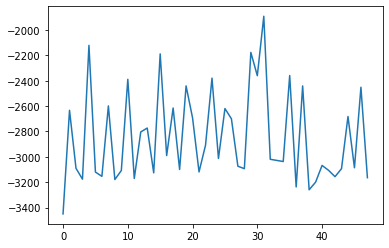

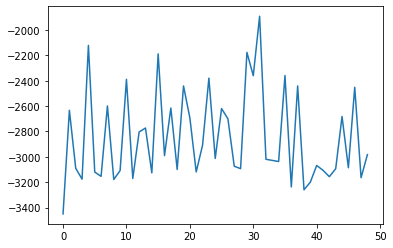

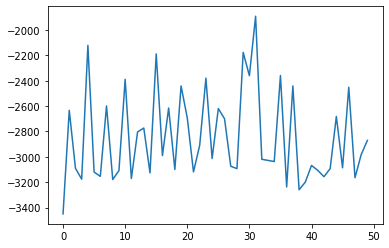

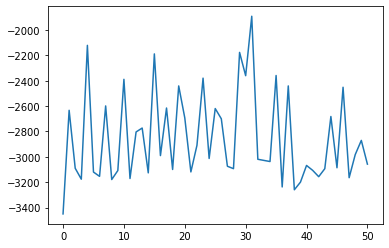

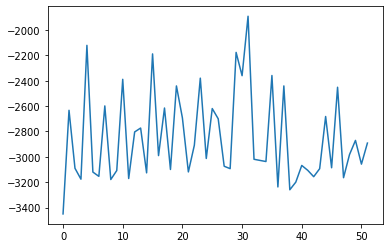

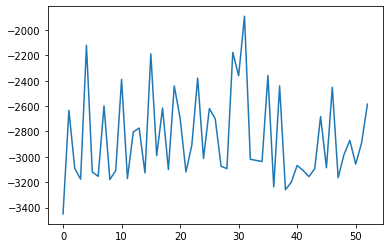

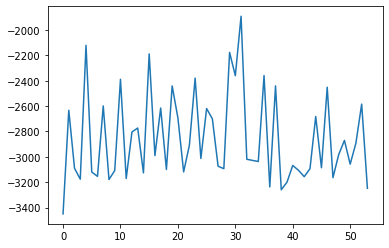

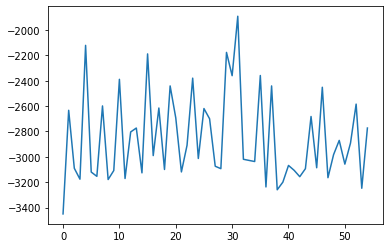

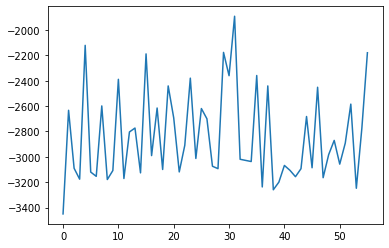

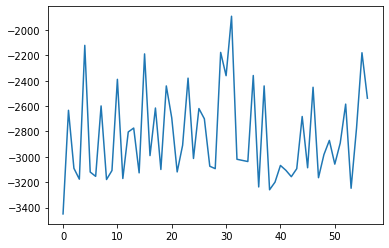

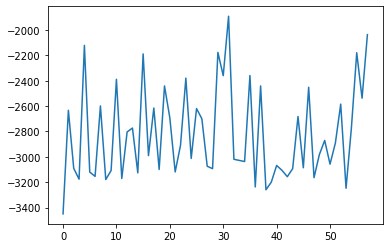

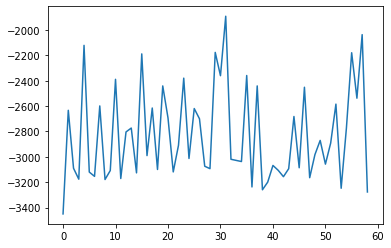

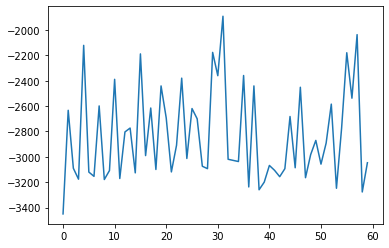

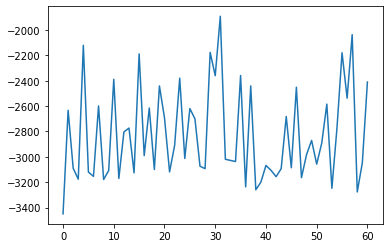

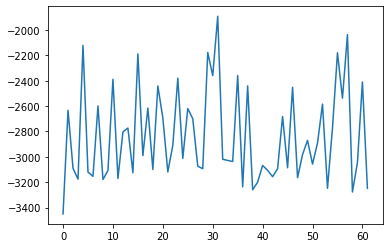

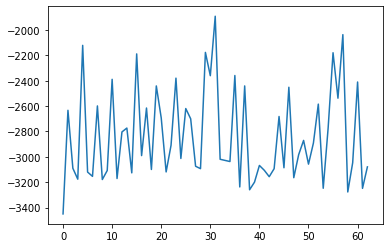

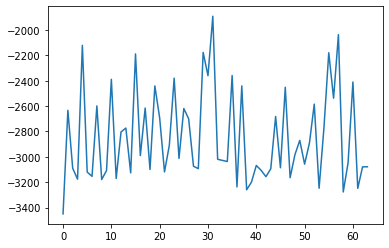

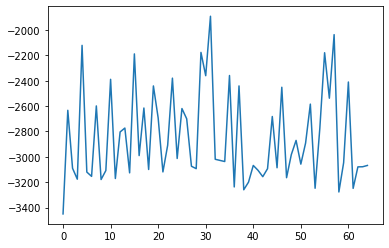

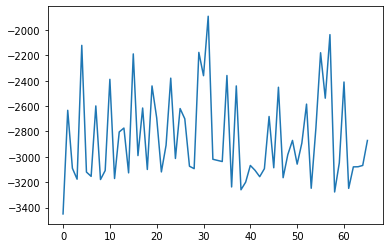

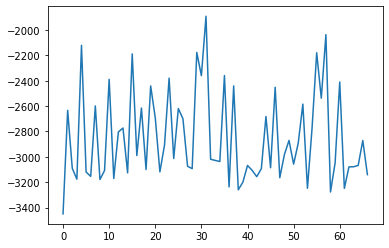

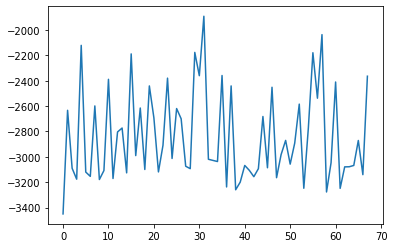

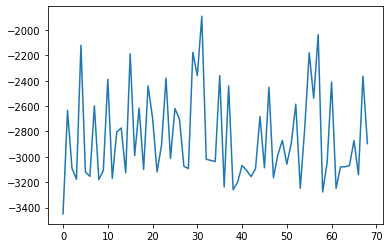

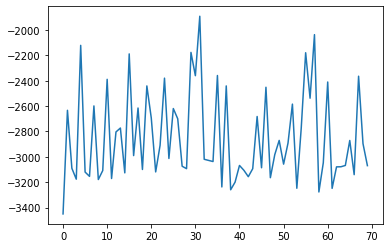

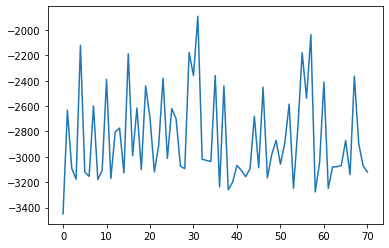

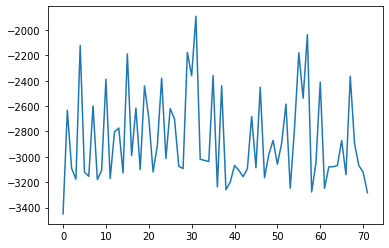

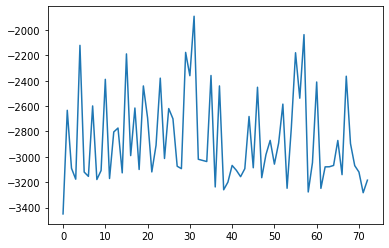

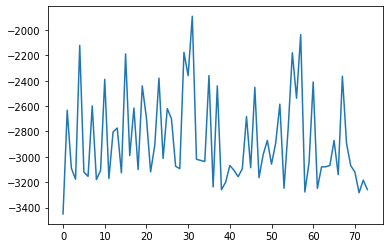

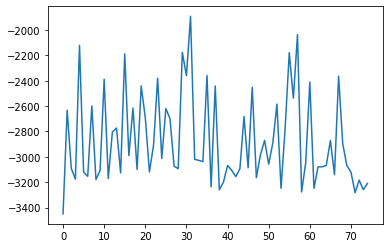

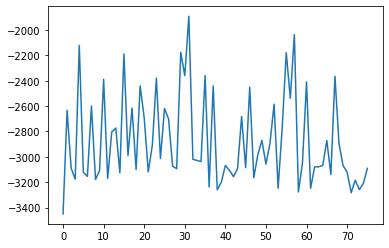

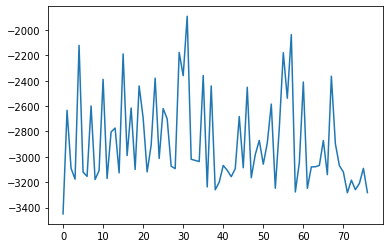

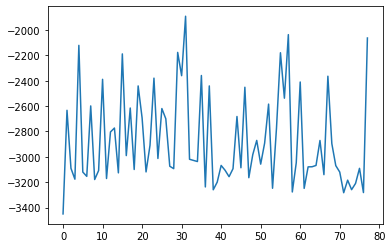

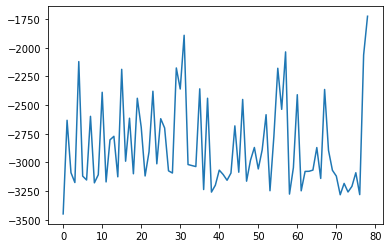

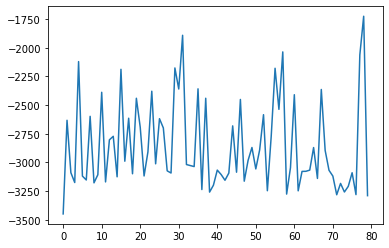

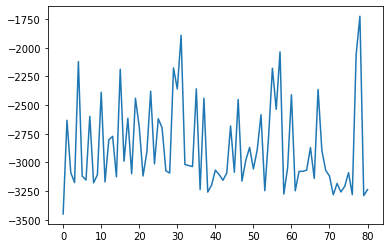

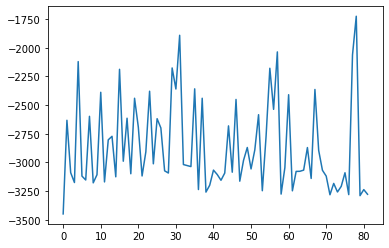

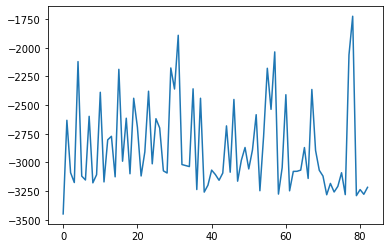

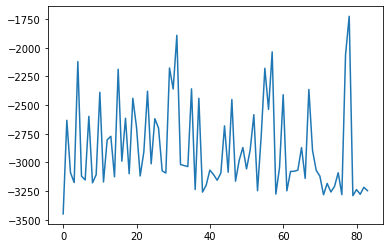

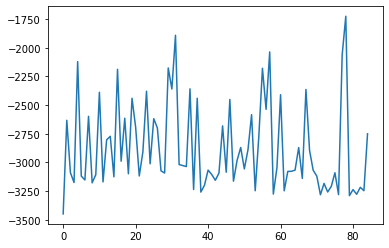

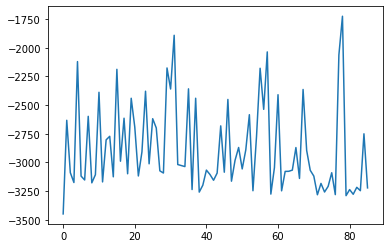

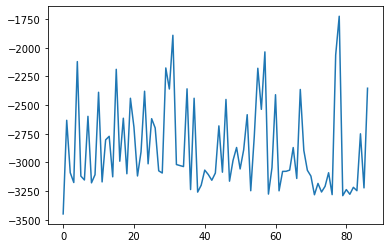

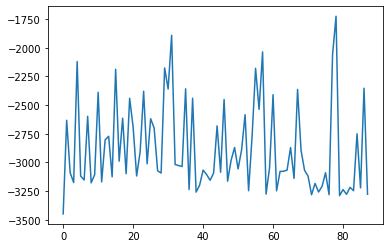

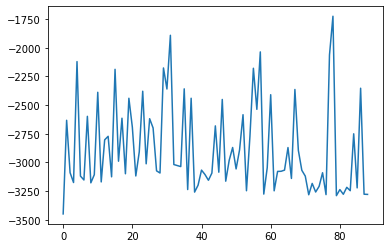

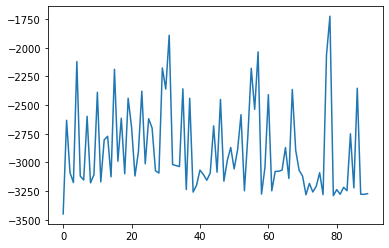

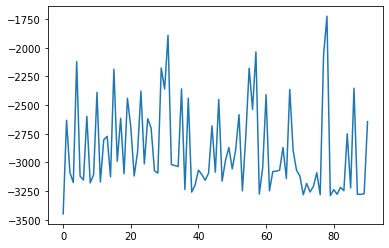

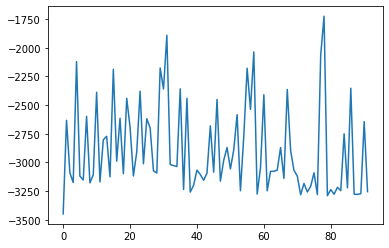

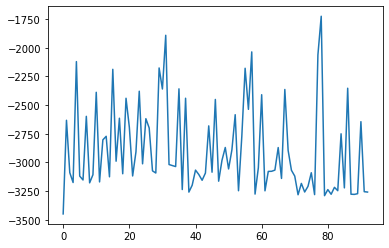

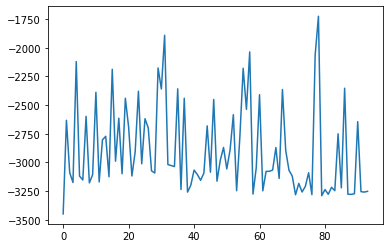

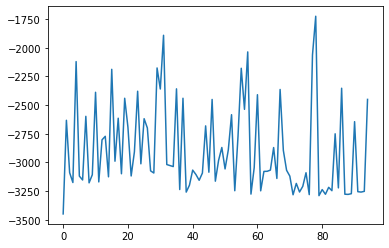

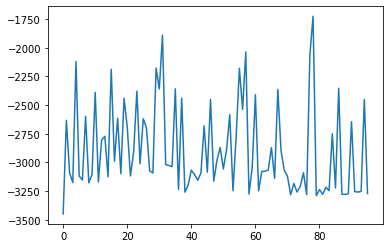

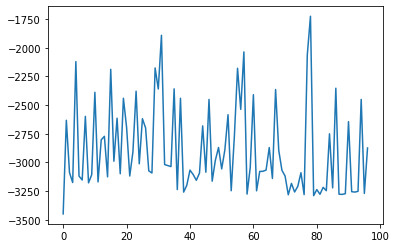

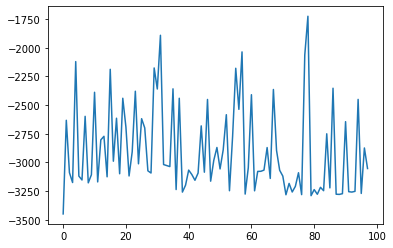

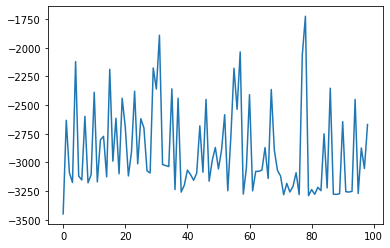

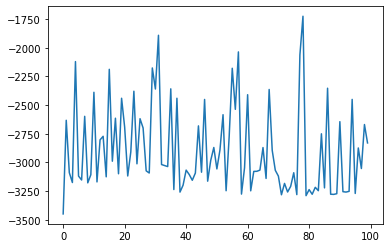

In [2]:
def main():
	sess = tf.Session()
	K.set_session(sess)
	env = gym.make("Pendulum-v0")
	actor_critic = ActorCritic(env, sess)

	num_trials = 100
	trial_len  = 200
	reward_list = []

	for i in range(num_trials):
		print("trial:" + str(i))
		cur_state = env.reset()
		action = env.action_space.sample()
		reward_sum = 0
		obs_list = []      
		act_list = []
		obs_list.append(cur_state)
		act_list.append(np.zeros((1,actor_critic.env.action_space.shape[0])))
		for j in range(trial_len):
			#env.render()        
			obs_seq = np.asarray(obs_list)
			act_seq = np.asarray(act_list)
			obs_seq = obs_seq.reshape((1, -1, env.observation_space.shape[0]))
			act_seq = act_seq.reshape((1, -1, env.action_space.shape[0]))
			action = actor_critic.act(obs_seq,act_seq)
			action = action.reshape((1, env.action_space.shape[0]))

			new_state, reward, done, _ = env.step(action)
			reward +=reward
			reward_sum += reward
			if j == (trial_len - 1):
				done = True
				print(reward_sum)
				reward_list.append(reward_sum)
				fig, ax = plt.subplots()
				ax.plot(reward_list)
				fig.savefig('/home/yunke/prl_proj/panda_ws/src/franka_cal_sim/python/pen_test.png')
				print(reward)

			if (j % 5 == 0):
				actor_critic.train()
				actor_critic.update_target()   
			
			new_state = new_state.reshape((env.observation_space.shape))
			action = action.reshape((env.action_space.shape))

			obs_list.append(new_state)
			act_list.append(action)
			next_obs_seq = np.asarray(obs_list)
			next_act_seq = np.asarray(act_list)
			next_obs_seq = next_obs_seq.reshape((1, -1, env.observation_space.shape[0]))
			next_act_seq = next_act_seq.reshape((1, -1, env.action_space.shape[0]))
            
			#padding
			pad_width = trial_len-np.size(obs_seq,1)
			obs_seq = np.pad(obs_seq,((0,0),(pad_width,0),(0,0)))
			next_obs_seq = np.pad(next_obs_seq,((0,0),(pad_width,0),(0,0)))
			act_seq = np.pad(act_seq,((0,0),(pad_width,0),(0,0)))
			next_act_seq = np.pad(next_act_seq,((0,0),(pad_width,0),(0,0)))
			#print(obs_seq.shape)
			#print(next_obs_seq.shape)
            
			actor_critic.remember(obs_seq, act_seq, action, reward, next_obs_seq, next_act_seq, done)
			cur_state = new_state

		if (i % 5 == 0) and i!=0:
			cur_state = env.reset()
			obs_list = []         
			act_list = []
			act_list.append(np.zeros((1,env.action_space.shape[0])))
			for j in range(500):
				env.render()
				cur_state = cur_state.reshape((1, env.observation_space.shape[0]))
				obs_list.append(cur_state)
				obs_seq = np.asarray(obs_list)
				act_seq = np.asarray(act_list)
				obs_seq = obs_seq.reshape((1, -1, env.observation_space.shape[0]))
				act_seq = act_seq.reshape((1, -1, env.action_space.shape[0]))
				action = actor_critic.act(obs_seq,act_seq)
				action = action.reshape((1, env.action_space.shape[0]))

				new_state, reward, done, _ = env.step(action)
				#reward += reward
				#if j == (trial_len - 1):
					#done = True
					#print(reward)

				#if (j % 5 == 0):
				#    actor_critic.train()
				#    actor_critic.update_target()   
				
				new_state = new_state.reshape((1, env.observation_space.shape[0]))

				#actor_critic.remember(cur_state, action, reward, new_state, done)
				cur_state = new_state
				act_list.append(action)

if __name__ == "__main__":
	main()